<a href="https://colab.research.google.com/github/gigihsantoso/Neural-Network-SMS-Text-Classifier/blob/main/fcc_sms_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

--2022-09-05 22:29:57--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv.2’

train-data.tsv.2    100%[===================>] 349.84K  --.-KB/s    in 0.004s  

2022-09-05 22:29:57 (82.6 MB/s) - ‘train-data.tsv.2’ saved [358233/358233]

--2022-09-05 22:29:57--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv.2’

valid-data.tsv.2    100%[====

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
train = pd.read_table('train-data.tsv', header=None, skiprows=2)
valid = pd.read_table('valid-data.tsv', header=None, skiprows=2)

In [ ]:
def labeling(x: tf.Tensor):
  label =  0 if x == "ham" else 1
  return tf.cast(tf.reshape(label, [1]), tf.int64)

In [ ]:
def dataframe_to_dataset(data, batch_size=32):
  df = data.copy()
  features = {'text': tf.expand_dims(df.pop(1), axis=-1)}
  labels = tf.expand_dims(df.pop(0), axis=-1)
  ds = tf.data.Dataset.from_tensor_slices((features, labels))
  ds = ds.map(lambda x,  y: (x, tf.py_function(func=labeling, inp=[y], Tout=tf.int64) ))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [ ]:
def text_to_vector(name, dataset, vocab):
  feature_dataset = dataset.map(lambda x,y: x[name])
  layer = tf.keras.layers.TextVectorization(
      max_tokens = vocab,
      standardize = "lower_and_strip_punctuation",
      pad_to_max_tokens=True,
      split = "whitespace",
      output_sequence_length=128,
      ngrams=(1,1),
      output_mode = "int"
  )
  layer.adapt(feature_dataset)

  return layer

In [ ]:
batch_size = 4
vocabSize = 10000
train_ds = dataframe_to_dataset(train, batch_size=batch_size)
valid_ds = dataframe_to_dataset(valid, batch_size=batch_size)

In [ ]:
  input = tf.keras.Input(shape=(1,), name='text', dtype="string")
  vector_layer = text_to_vector(name='text', dataset=train_ds, vocab=vocabSize)
  vector_preprocessor = vector_layer(input)

In [ ]:
all_features = tf.keras.layers.Embedding(vocabSize, 128, mask_zero=True)(vector_preprocessor)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.2, return_sequences=True))(all_features)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2))(x)
x = tf.keras.layers.Dense(64, activation=tf.keras.activations.relu)(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)(x)
model = tf.keras.Model(input, output)

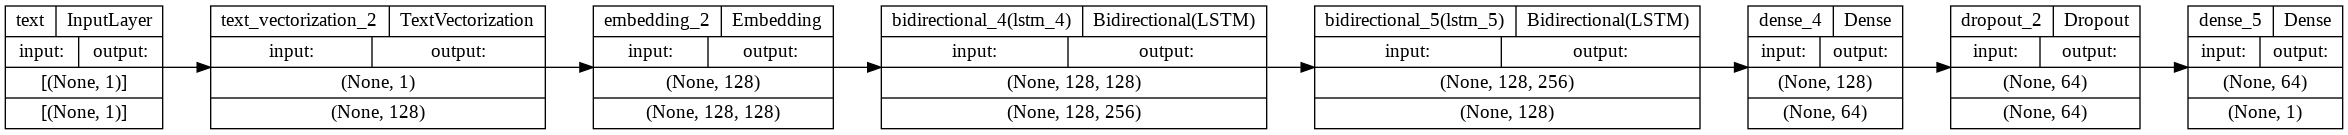

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.SensitivityAtSpecificity(0.5, name='specificity')
]
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=METRICS)

In [ ]:
loss = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
val_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_ds, epochs=20, validation_data=valid_ds, callbacks=[loss, val_loss])

Epoch 1/20
1045/1045 [==============================] - 69s 50ms/step - loss: 0.1360 - tp: 435.0000 - fp: 57.0000 - tn: 3560.0000 - fn: 125.0000 - accuracy: 0.9564 - precision: 0.8841 - recall: 0.7768 - specificity: 0.9768 - val_loss: 0.0585 - val_tp: 172.0000 - val_fp: 7.0000 - val_tn: 1196.0000 - val_fn: 15.0000 - val_accuracy: 0.9842 - val_precision: 0.9609 - val_recall: 0.9198 - val_specificity: 0.9893
Epoch 2/20
1045/1045 [==============================] - 48s 46ms/step - loss: 0.0262 - tp: 539.0000 - fp: 11.0000 - tn: 3606.0000 - fn: 21.0000 - accuracy: 0.9923 - precision: 0.9800 - recall: 0.9625 - specificity: 0.9964 - val_loss: 0.0616 - val_tp: 171.0000 - val_fp: 10.0000 - val_tn: 1193.0000 - val_fn: 16.0000 - val_accuracy: 0.9813 - val_precision: 0.9448 - val_recall: 0.9144 - val_specificity: 0.9733
Epoch 3/20
1045/1045 [==============================] - 49s 47ms/step - loss: 0.0105 - tp: 552.0000 - fp: 3.0000 - tn: 3614.0000 - fn: 8.0000 - accuracy: 0.9974 - precision: 0.9946

In [ ]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  input_dict = {'text': tf.convert_to_tensor([pred_text])}
  predic = model.predict(input_dict)
  prediction = [predic[0][0], "ham" if predic[0][0] < 0.5 else "spam"] 
  return (prediction)

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

[0.00028665725, 'ham']


In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


You passed the challenge. Great job!
